In [2]:
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext, SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import cm
import numpy as np

In [3]:
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext.getOrCreate(spark.sparkContext)

In [4]:
sc = SparkSession.builder.appName("PysparkExample").config ("spark.sql.shuffle.partitions", "50").config("spark.driver.maxResultSize","5g").config ("spark.sql.execution.arrow.enabled", "true").getOrCreate()

In [5]:
dataframe_csv = sc.read.csv('news.csv',header = 'True',inferSchema='True')

In [73]:
news_df.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|             authors|               title|        publish_date|         description|                text|                 url|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|        ['Cbc News']|Coronavirus a 'wa...|      3/27/2020 8:00|Canadian pharmaci...|"Canadian pharmac...|"" he said.  Tadr...|
|  1|        ['Cbc News']|Yukon gov't names...|      3/27/2020 1:45|The Yukon governm...|"The Yukon govern...|  from March 9 to 13|
|  2|['The Associated ...|U.S. Senate passe...|      3/26/2020 5:13|The Senate has pa...|"The Senate late ...|"" said Democrati...|
|  3|        ['Cbc News']|Coronavirus: The ...|      3/27/2020 0:36|Scientists around...|"Scientists aroun...| "" said Zarychanski|
|  4|        ['Cbc News']|The latest on the...|     3/26/2020 20:57|The late

In [75]:
#clean columns, remove smybols
from pyspark.sql.functions import *
def cleanColumn(tmpdf,colName,findChar,replaceChar):
    tmpdf = tmpdf.withColumn(colName, regexp_replace(colName, findChar, replaceChar))
    return tmpdf

allColNames = news_df.schema.names
charToRemove= "[\"!@#$%^&*\(\)\{\}\[\]\'\'""',.?/:;-=+`~'...''..']"
replaceWith =""
for colName in allColNames:
    news_df=cleanColumn(news_df,colName,charToRemove,replaceWith)

In [77]:
news_df.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|             authors|               title|        publish_date|         description|                text|                 url|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|            Cbc News|Coronavirus a wak...|         3272020 800|Canadian pharmaci...|Canadian pharmaci...| he said  Tadrous...|
|  1|            Cbc News|Yukon govt names ...|         3272020 145|The Yukon governm...|The Yukon governm...|  from March 9 to 13|
|  2|The Associated Press|US Senate passes ...|         3262020 513|The Senate has pa...|The Senate late W...| said Democratic ...|
|  3|            Cbc News|Coronavirus The l...|         3272020 036|Scientists around...|Scientists around...|    said Zarychanski|
|  4|            Cbc News|The latest on the...|        3262020 2057|The late

In [79]:
#drop column _c0
news_df = news_df.drop('_c0')
news_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             authors|               title|        publish_date|         description|                text|                 url|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            Cbc News|Coronavirus a wak...|         3272020 800|Canadian pharmaci...|Canadian pharmaci...| he said  Tadrous...|
|            Cbc News|Yukon govt names ...|         3272020 145|The Yukon governm...|The Yukon governm...|  from March 9 to 13|
|The Associated Press|US Senate passes ...|         3262020 513|The Senate has pa...|The Senate late W...| said Democratic ...|
|            Cbc News|Coronavirus The l...|         3272020 036|Scientists around...|Scientists around...|    said Zarychanski|
|            Cbc News|The latest on the...|        3262020 2057|The latest on the...|    Trudeau says ..

In [81]:
#drop rows with NAs/ Null values
def dropNA (tmpdf2,columnName):
    tmpdf2 = tmpdf2.where(col(columnName).isNotNull())
    return tmpdf2

columnName = ["authors","title","publish_date","description","text","url"]
allColNames2 = news_df.schema.names

for columnName in allColNames2:
    news_df = dropNA(news_df,columnName)

In [83]:
news_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             authors|               title|        publish_date|         description|                text|                 url|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            Cbc News|Coronavirus a wak...|         3272020 800|Canadian pharmaci...|Canadian pharmaci...| he said  Tadrous...|
|            Cbc News|Yukon govt names ...|         3272020 145|The Yukon governm...|The Yukon governm...|  from March 9 to 13|
|The Associated Press|US Senate passes ...|         3262020 513|The Senate has pa...|The Senate late W...| said Democratic ...|
|            Cbc News|Coronavirus The l...|         3272020 036|Scientists around...|Scientists around...|    said Zarychanski|
|            Cbc News|The latest on the...|        3262020 2057|The latest on the...|    Trudeau says ..

In [85]:
# print schema to know what to query against
news_df.printSchema()

root
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



In [87]:
#create tmp table view
news_df.createOrReplaceTempView("count_table")

In [88]:
#count # of authors
filtered_count_df = spark.sql("SELECT COUNT (DISTINCT authors) AS Author_Count FROM count_table")
filtered_count_df.show()

+------------+
|Author_Count|
+------------+
|         261|
+------------+



In [89]:
#groupby publish_date to see how many articles were published daily and by time stamp
news_df.groupBy("publish_date").count().show()

+------------+-----+
|publish_date|count|
+------------+-----+
| 2202020 057|    1|
|1292020 1709|    1|
| 3262020 241|    1|
|3252020 1740|    1|
|3232020 1701|    1|
|3232020 1400|    2|
|3132020 2033|    2|
|3202020 1923|    2|
|3152020 2355|    1|
|3142020 1300|    1|
| 3262020 038|    1|
|3172020 1116|    1|
|  312020 900|    3|
| 382020 2117|    1|
| 522013 1514|    1|
|3262020 1417|    1|
|3122020 1059|    1|
|3182020 1333|    1|
|3162020 1000|    2|
|8222013 1439|    1|
+------------+-----+
only showing top 20 rows



In [90]:
# groupby and count # of authors
news_df.groupBy("authors").count().show()

+--------------------+-----+
|             authors|count|
+--------------------+-----+
|Andrea Bellemare ...|    4|
|Briar Stewart Is ...|    1|
|Business Columnis...|    9|
|Carolyn Ray Is A ...|    3|
|Jim Agapito Is A ...|    1|
|Reporter Cbc Toro...|    4|
|Jennifer Sweet Is...|    3|
|Cbc Saskatchewan ...|    2|
|Renée Is A Cbc Co...|    2|
|      Elham Shabahat|    1|
|Dan Mcgarvey Is A...|    2|
|Jonathan Montpeti...|    2|
|Senior Producer W...|    3|
|Elias Abboud Is A...|    1|
|Video Journalist ...|    1|
|Reporter-Editor C...|    4|
|Peter Mills Is An...|    3|
|Reporter Editor J...|   14|
|Dr Taylor Loughee...|    1|
|Raffy Boudjikania...|    2|
+--------------------+-----+
only showing top 20 rows



In [91]:
# groupby and count # of titles, shows duplicate titles
news_df.groupBy("title").count().show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|Michigan governor...|    1|
|Chinas coronaviru...|    1|
|More artists post...|    1|
|1 in 3 Canadians ...|    1|
|    MERS coronavirus|    1|
|Stranded abroad W...|    2|
|Seafood plants sc...|    1|
|Ottawa will allow...|    1|
|Send in the troll...|    1|
|Mayor assures Win...|    1|
|Saskatoon cannabi...|    1|
|Independent shops...|    1|
| Jorgebarrera Or ...|    5|
|Montreal-area hig...|    1|
|UWindsor St Clair...|    1|
|Coronavirus quiz ...|    1|
|China reports 15 ...|    1|
|As civil libertie...|    2|
|ICU chief contact...|    2|
|No new COVID-19 c...|    2|
+--------------------+-----+
only showing top 20 rows



In [92]:
# groupby and count # of description shows duplicate descriptions
news_df.groupBy("description").count().show()

+--------------------+-----+
|         description|count|
+--------------------+-----+
|The state of Mich...|    1|
|A case of the nov...|    1|
|School trips are ...|    1|
|McMaster Universi...|    1|
|Travel and touris...|    1|
|Alberta has boost...|    1|
|Provincial health...|    1|
|Economists are bu...|    2|
|Manitobans lookin...|    2|
|As museums close ...|    1|
|If a team of UPEI...|    3|
|        3202020 1955|    3|
|Acting White Hous...|    1|
|The director of e...|    1|
|Several employees...|    1|
|30 per cent more ...|    1|
|BCs 2020 Summer G...|    1|
|The Yukon governm...|    1|
|In the week since...|    1|
|The Town of Happy...|    1|
+--------------------+-----+
only showing top 20 rows



In [93]:
# groupby and count # of url shows duplicate descriptions
news_df.groupBy("url").count().show()

+--------------------+-----+
|                 url|count|
+--------------------+-----+
| Johnson said in ...|    1|
|httpswwwcbccanews...|    1|
| Kenney said Mond...|    1|
| said UVic presid...|    1|
| he said So you h...|    1|
| said Tyler Misla...|    2|
| said Myriam Laro...|    1|
|   said Jon Ola Sand|    1|
|664 Canadian adul...|    1|
| it is not clear ...|    1|
|    Zarychanski said|    1|
| awaiting results...|    1|
|httpswwwcbccanews...|    1|
| the city said in...|    2|
| not focused on a...|    2|
| Hamiltons medica...|    1|
| Nui told Labrado...|    2|
|Instead of being ...|    1|
| and then any tim...|    1|
|             Fei Liu|    2|
+--------------------+-----+
only showing top 20 rows



In [94]:
#Stop word removal code from DataCamp
# Create a baseRDD from the file path
sc = spark.sparkContext

baseRDD = sc.textFile(r"C:\Users\Junji\Documents\GitHub\team-mount-elbert\news.csv")

# Split the lines of baseRDD into words
splitRDD = baseRDD.flatMap(lambda x: x.split())

# Count the total number of words
print("Total number of words in splitRDD:", splitRDD.count())

Total number of words in splitRDD: 2734102


In [95]:
stop_words = ['whence', 'here', 'show', 'were', 'why', 'n’t', 'the', 'whereupon', 'not', 'more', 'how', 'eight', 'indeed', 
              'i', 'only', 'via', 'nine', 're', 'themselves', 'almost', 'to', 'already', 'front', 'least', 'becomes', 
              'thereby', 'doing', 'her', 'together', 'be', 'often', 'then', 'quite', 'less', 'many', 'they', 'ourselves', 
              'take', 'its', 'yours', 'each', 'would', 'may', 'namely', 'do', 'whose', 'whether', 'side', 'both', 'what', 
              'between', 'toward', 'our', 'whereby', "'m", 'formerly', 'myself', 'had', 'really', 'call', 'keep', "'re", 
              'hereupon', 'can', 'their', 'eleven', '’m', 'even', 'around', 'twenty', 'mostly', 'did', 'at', 'an', 'seems', 
              'serious', 'against', "n't", 'except', 'has', 'five', 'he', 'last', '‘ve', 'because', 'we', 'himself', 'yet', 
              'something', 'somehow', '‘m', 'towards', 'his', 'six', 'anywhere', 'us', '‘d', 'thru', 'thus', 'which', 
              'everything', 'become', 'herein', 'one', 'in', 'although', 'sometime', 'give', 'cannot', 'besides', 'across', 
              'noone', 'ever', 'that', 'over', 'among', 'during', 'however', 'when', 'sometimes', 'still', 'seemed', 'get', 
              "'ve", 'him', 'with', 'part', 'beyond', 'everyone', 'same', 'this', 'latterly', 'no', 'regarding', 'elsewhere', 
              'others', 'moreover', 'else', 'back', 'alone', 'somewhere', 'are', 'will', 'beforehand', 'ten', 'very', 'most', 
              'three', 'former', '’re', 'otherwise', 'several', 'also', 'whatever', 'am', 'becoming', 'beside', '’s', 'nothing', 
              'some', 'since', 'thence', 'anyway', 'out', 'up', 'well', 'it', 'various', 'four', 'top', '‘s', 'than', 'under', 'might', 
              'could', 'by', 'too', 'and', 'whom', '‘ll', 'say', 'therefore', "'s", 'other', 'throughout', 'became', 'your', 'put', 'per', 
              "'ll", 'fifteen', 'must', 'before', 'whenever', 'anyone', 'without', 'does', 'was', 'where', 'thereafter', "'d", 'another', 
              'yourselves', 'n‘t', 'see', 'go', 'wherever', 'just', 'seeming', 'hence', 'full', 'whereafter', 'bottom', 'whole', 'own', 
              'empty', 'due', 'behind', 'while', 'onto', 'wherein', 'off', 'again', 'a', 'two', 'above', 'therein', 'sixty', 'those', 
              'whereas', 'using', 'latter', 'used', 'my', 'herself', 'hers', 'or', 'neither', 'forty', 'thereupon', 'now', 'after', 
              'yourself', 'whither', 'rather', 'once', 'from', 'until', 'anything', 'few', 'into', 'such', 'being', 'make', 'mine', 
              'please', 'along', 'hundred', 'should', 'below', 'third', 'unless', 'upon', 'perhaps', 'ours', 'but', 'never', 'whoever', 
              'fifty', 'any', 'all', 'nobody', 'there', 'have', 'anyhow', 'of', 'seem', 'down', 'is', 'every', '’ll', 'much', 'none', 
              'further', 'me', 'who', 'nevertheless', 'about', 'everywhere', 'name', 'enough', '’d', 'next', 'meanwhile', 'though', 
              'through', 'on', 'first', 'been', 'hereby', 'if', 'move', 'so', 'either', 'amongst', 'for', 'twelve', 'nor', 'she', 'always', 
              'these', 'as', '’ve', 'amount', '‘re', 'someone', 'afterwards', 'you', 'nowhere', 'itself', 'done', 'hereafter', 'within', 
              'made', 'ca', 'them', 'said', 'said.', '— has', 'says', '— has', '—','""We']

In [96]:
# Convert the words in lower case and remove stop words from stop_words
splitRDD_no_stop = splitRDD.filter(lambda x: x.lower() not in stop_words)

# Create a tuple of the word and 1 
splitRDD_no_stop_words = splitRDD_no_stop.map(lambda w: (w, 1))

# Count of the number of occurences of each word 
resultRDD = splitRDD_no_stop_words.reduceByKey(lambda x, y: x + y)

In [97]:
# Swap the keys and values
resultRDD_swap = resultRDD.map(lambda x: (x[1], x[0]))

# Sort the keys in descending order
resultRDD_swap_sort = resultRDD_swap.sortByKey(ascending=False)

# Show the top 10 most frequent words and their frequencies
for word in resultRDD_swap_sort.take(10):
	print("{} has {} counts". format(word[1], word[0]))

COVID-19 has 12123 counts
people has 11326 counts
health has 8979 counts
coronavirus has 7697 counts
cases has 6950 counts
new has 5099 counts
public has 4953 counts
Health has 4927 counts
government has 4434 counts
Canada has 4396 counts


In [98]:
new_results_df = spark.createDataFrame(resultRDD_swap_sort)
new_results_df.createOrReplaceTempView("Word_Count")

In [99]:
data = new_results_df.select(col("_1").alias("count"), col("_2").alias("word"))

In [100]:
data.show()

+-----+-----------+
|count|       word|
+-----+-----------+
|12123|   COVID-19|
|11326|     people|
| 8979|     health|
| 7697|coronavirus|
| 6950|      cases|
| 5099|        new|
| 4953|     public|
| 4927|     Health|
| 4434| government|
| 4396|     Canada|
| 3874|     spread|
| 3701|       need|
| 3657|       home|
| 3563|  confirmed|
| 3328|      virus|
| 3302|      March|
| 3279|       it's|
| 3228|   province|
| 3006|  officials|
| 2966|       ""We|
+-----+-----------+
only showing top 20 rows



In [101]:
top_10 = data.take(10)
top_10

[Row(count=12123, word='COVID-19'),
 Row(count=11326, word='people'),
 Row(count=8979, word='health'),
 Row(count=7697, word='coronavirus'),
 Row(count=6950, word='cases'),
 Row(count=5099, word='new'),
 Row(count=4953, word='public'),
 Row(count=4927, word='Health'),
 Row(count=4434, word='government'),
 Row(count=4396, word='Canada')]

In [102]:
pdDF = pd.DataFrame(data.take(15), columns=data.columns)
pdDF

,count,word
0,12123,COVID-19
1,11326,people
2,8979,health
3,7697,coronavirus
4,6950,cases
5,5099,new
6,4953,public
7,4927,Health
8,4434,government
9,4396,Canada


<Figure size 432x288 with 0 Axes>

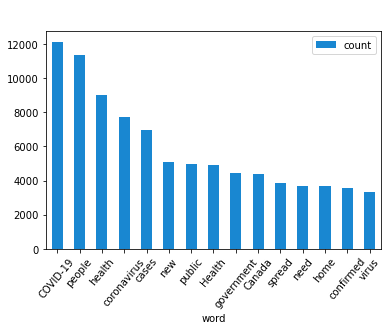

In [103]:
#color = cm.PuRd_r(np.linspace(.1, .4, 20))
plt.clf()
pdDF.plot(x='word',  y='count', kind='bar', color='#007acc', alpha=0.9, linewidth=5, rot=50)
plt.title("Covid-19 Word Count", color='w', fontsize=25)
display()

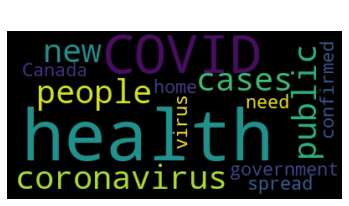

In [104]:
wordcloud = WordCloud().generate(' '.join(pdDF['word']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Covid-19 Word Cloud", color='w', fontsize=25)
plt.show()

In [106]:
#write to parquet file
news_df.write.parquet('news_df_parquet')